### **Actuarial Project**

#### **Phase Three: Severity Model**

In [ ]:
# Installing & Importing Python packages
!pip -q install statsmodels

import pandas as pd                                              # For data manipulation and analysis
import numpy as np                                               # For numerical operations
import seaborn as sns                                            # For data visualization
import matplotlib.pyplot as plt                                  # For creating visualizations
import statsmodels.api as sm                                     # For statistical modeling
from statsmodels.miscmodels.ordinal_model import OrderedModel    #
from sklearn.model_selection import train_test_split             # For splitting data into training and testing sets

# To ignore warnings
import warnings                                                  # To handle warnings
warnings.filterwarnings("ignore")                                # Suppress all warnings

In [ ]:
# Import dataset
insurance_data = pd.read_csv('/content/drive/MyDrive/Actuarial Project/model_ready_insurance_data.csv')

insurance_data.head()

,Age,Is_Senior,Marital_Status,Married_Premium_Discount,Prior_Insurance,Prior_Insurance_Premium_Adjustment,Claims_Frequency,Claims_Severity,Claims_Adjustment,Policy_Type,...,Premium_Adjustment_Region,Risk_Tier,Loyalty_Band,Engagement_Score,Engagement_Level,Source_of_Lead_Agent,Source_of_Lead_Referral,Region_Urban,Region_Suburban,Expected_Claim_Freq
0,47,0,1,86,1,50,0,0,0,1,...,50,0,1,13,1,1,0,0,1,0.363514
1,37,0,1,86,1,50,0,0,0,1,...,100,0,1,13,1,0,0,1,0,0.351234
2,49,0,1,86,1,50,1,0,50,1,...,100,0,1,15,1,0,0,1,0,0.344120
3,62,1,1,86,2,0,1,0,50,1,...,100,0,2,16,2,0,0,1,0,0.338698
4,36,0,0,0,2,0,2,0,100,1,...,50,1,2,22,2,1,0,0,1,0.626310


#### **modelling target & features (No pricing features)**

In [ ]:
TARGET = "Claims_Severity"

candidate_features = [
    "Age",
    "Risk_Tier",              # 0/1/2 (Low/Med/High)
    "Policy_Type",            # 0/1 (Full Coverage=1)
    "Prior_Insurance",        # 0/1/2 (<1,1-5,>5)
    "Marital_Status",         # 0/1 (Married=1)
    "Is_Senior",              # 0/1
    "Credit_Score",
    "Engagement_Score",
    "Region_Urban", "Region_Suburban"  # baseline = Rural
    # (Optionally) Loyalty_Band, Safe_Driver_Discount, Multi_Policy_Discount, Bundling_Discount
]

FEATURES = [c for c in candidate_features if c in insurance_data.columns]
print("Severity features:", FEATURES)


Severity features: ['Age', 'Risk_Tier', 'Policy_Type', 'Prior_Insurance', 'Marital_Status', 'Is_Senior', 'Credit_Score', 'Engagement_Score', 'Region_Urban', 'Region_Suburban']


#### **Train/validation split**

In [ ]:
train_s, test_s = train_test_split(insurance_data, test_size=0.25, random_state=42, stratify=insurance_data[TARGET])

X_train_s = train_s[FEATURES].copy()
y_train_s = train_s[TARGET].astype(int).copy()

X_test_s  = test_s[FEATURES].copy()
y_test_s  = test_s[TARGET].astype(int).copy()

# We don’t add a constant like GLM because OrderedModel adds thresholds (cutpoints) internally.

#### **Fit the Ordered Logit model**

In [ ]:
ordered_logit = OrderedModel(
    endog=y_train_s,
    exog=X_train_s,
    distr='logit'      # 'probit' also common; logit is standard & interpretable
)

ordered_res = ordered_logit.fit(method='bfgs', disp=False)
print(ordered_res.summary())


                             OrderedModel Results                             
Dep. Variable:        Claims_Severity   Log-Likelihood:                -1800.0
Model:                   OrderedModel   AIC:                             3624.
Method:            Maximum Likelihood   BIC:                             3707.
Date:                Wed, 05 Nov 2025                                         
Time:                        22:57:28                                         
No. Observations:                7500                                         
Df Residuals:                    7488                                         
Df Model:                          10                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Age                  0.0033      0.004      0.755      0.450      -0.005       0.012
Risk_Tier            5.9109      0

#### **Predict class probabilities for each band**

In [ ]:
# Predict probabilities on test set
pred_probs_test = ordered_res.predict(X_test_s)
pred_probs_test[:5]  # preview first 5


,0,1,2
7472,0.993652,0.006294,0.000054
8146,0.270744,0.706971,0.022285
4917,0.992588,0.007349,0.000063
9106,0.001115,0.115459,0.883425
3433,0.992832,0.007107,0.000061


In [ ]:
yhat_band = pred_probs_test.values.argmax(axis=1)


#### **Map bands to a severity cost and compute Expected Severity Cost**

In [ ]:
# Define cost per band
severity_costs = np.array([500.0, 2000.0, 15000.0])  # Low, Medium, High

# Expected cost = P(Low)*500 + P(Med)*2000 + P(High)*15000
exp_sev_cost_test = (pred_probs_test.values * severity_costs).sum(axis=1)

# Attach to test frame for inspection
test_eval = test_s[[TARGET]].copy()
test_eval["P_Low"] = pred_probs_test.values[:,0]
test_eval["P_Med"] = pred_probs_test.values[:,1]
test_eval["P_High"] = pred_probs_test.values[:,2]
test_eval["Pred_Band"] = yhat_band
test_eval["Expected_Severity_Cost"] = exp_sev_cost_test
test_eval.head()


,Claims_Severity,P_Low,P_Med,P_High,Pred_Band,Expected_Severity_Cost
7472,0,0.993652,0.006294,0.000054,0,510.224931
8146,0,0.270744,0.706971,0.022285,1,1883.590547
4917,0,0.992588,0.007349,0.000063,0,511.939867
9106,0,0.001115,0.115459,0.883425,2,13482.856769
3433,0,0.992832,0.007107,0.000061,0,511.546382


#### **Quick validation: Band prediction accuracy**

In [ ]:
acc = (yhat_band == y_test_s.values).mean()
print(f"Band accuracy: {acc:.3f}")

Band accuracy: 0.933


#### **Cost calibration by deciles of predicted severity cost**
We’ll check if higher predicted severity cost segments really have higher observed severity (by band code).

In [ ]:
# Observed cost proxy from actual bands
obs_cost_test = severity_costs[y_test_s.values]

# Build calibration table by predicted expected severity cost deciles
tmp = pd.DataFrame({
    "obs_cost": obs_cost_test,
    "pred_cost": exp_sev_cost_test
})
tmp["decile"] = pd.qcut(tmp["pred_cost"].rank(method="first"), 10, labels=False)

calib_sev = tmp.groupby("decile").agg(
    avg_pred_cost=("pred_cost","mean"),
    avg_obs_cost =("obs_cost","mean"),
    n=("obs_cost","size")
).reset_index()

calib_sev


,decile,avg_pred_cost,avg_obs_cost,n
0,0,510.185619,500.0,250
1,1,510.980721,500.0,250
2,2,511.504477,500.0,250
3,3,511.999866,500.0,250
4,4,512.615985,500.0,250
5,5,513.497233,500.0,250
6,6,1345.908490,1232.0,250
7,7,1880.133760,1700.0,250
8,8,3056.689748,2804.0,250
9,9,13673.364149,13238.0,250


#### **Plot Observed vs Predicted**

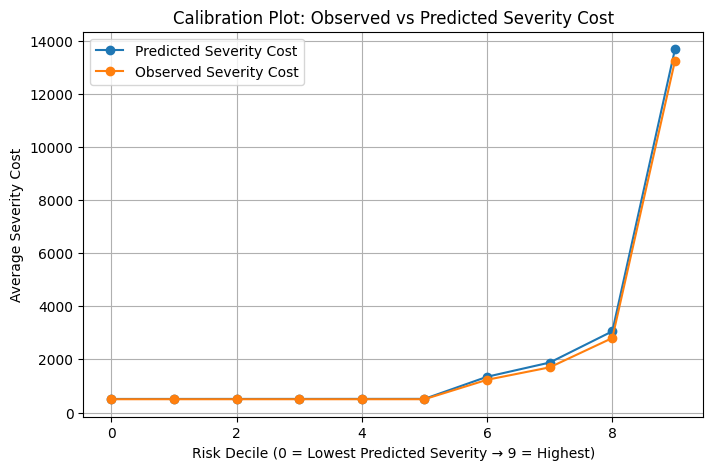

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(calib_sev["decile"], calib_sev["avg_pred_cost"], marker='o', label="Predicted Severity Cost")
plt.plot(calib_sev["decile"], calib_sev["avg_obs_cost"],  marker='o', label="Observed Severity Cost")

plt.xlabel("Risk Decile (0 = Lowest Predicted Severity → 9 = Highest)")
plt.ylabel("Average Severity Cost")
plt.title("Calibration Plot: Observed vs Predicted Severity Cost")
plt.legend()
plt.grid(True)
plt.show()


#### Add Expected_Severity_Cost into the original dataset

In [ ]:
# Predict probabilities on FULL data
pred_probs_full = ordered_res.predict(insurance_data[FEATURES])
insurance_data["Expected_Severity_Cost"] = (pred_probs_full.values * severity_costs).sum(axis=1)

# Save back to the same file (overwrite)
insurance_data.to_csv('/content/drive/MyDrive/Actuarial Project/model_ready_insurance_data.csv', index=False)

insurance_data[["Expected_Severity_Cost"]].head()


,Expected_Severity_Cost
0,512.039464
1,511.139833
2,512.151295
3,512.993935
4,1826.849233
